# 第三讲： 写作文本中的词汇分析
本课目标：
-	介绍写作评估中常用的词汇评价方法
-	学习使用NLP技术进行文本的分词、词性标注、语义分析等
-	利用给定的数据集生成词汇密度、词汇多样性、词汇复杂度等指标

## 1. 研究背景【秦】：
【简述智能写作评估中词汇的作用，推荐3-5篇关键文献】  
写作研究长期以来一直是英语研究（EFL research, English as Foreign Language research）中的一个重要分支。为了识别写作的潜在发展轨迹及其与学习者其他认知能力（如语言熟练度）之间的关系，已经开发出多种测量方法来识别写作中使用的语言的复杂度。这些测量方法通常被称为语言复杂度指标。  
**语言复杂度**被定义为使用更高级的语言形式和功能的能力，这些通常是在第二语言或外语发展的后期获得的（Ellis, 2009; Pallotti, 2015）。语言复杂度长期以来被视为一个多维构念，涵盖了在不同语言层面（即词汇、句法和结构层面）对语言的复杂使用。为了更好地大规模分析这些语言特征，许多研究人员开发了工具来自动化这些分析过程。在本讲中，我们将简要讨论各种语言复杂度指标的测量方法，以及如何自动提取和分析学习者写作中的这些特征。


## 2. 导入数据
请下载第三讲对应的数据文件，并且在Python中读入数据

In [18]:
%pip install -r requirements.txt
!python -m spacy download en_core_web_sm


Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 14.9 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [19]:
import os
# read the txt file in the data directory and save the data in the dict
essay_dict = {}
files = os.listdir('./DATA') # list of files in the DATA directory
for file in files:
    if file.endswith('.txt'): # only read the txt file
        with open('./DATA/'+file, 'r', encoding="utf-8-sig") as f: # open the files
            essay = f.read()
            essay_dict[file] = essay # save the data in the dict

# show the data in the dict
result = {}
os.makedirs('./result', exist_ok=True)
for key, value in essay_dict.items():
    print(f"Filename: {key}")
    print(f"Essay: {value}")
    print("------------------------------------")
    result[key] = {} # save the result in the dict

Filename: 10.txt
Essay: Cloning is mutually advancement in biotechnology and with adequate regulations imposed, it will be benefit human races.
From the technical aspect, two perfectly identical human is impossible. The cloning procedure only copies the genetic information of a human, but it cannot replicate the environment and incidents one has experienced. Post-utero environment is determinant either on epigenomes or mental issues, for it will change the gene expression and shape one’s thought. Meanwhile, lots of gene loci haven’t been well interpreted and researchers mainly target pathogenic gene to find cure from the root. It is unnecessary to dream that a ‘perfect Aryanne’ will be produced by the Third Reich fascists. At last, any alterations in gene sequence increase the risk of mutation. For mutation is principally random, it will inevitably change the appearance of the newly cloned human.
Given that the technology is still marching to maturity by now, there may be less ethical 

## 3. 数据预处理
在展开词汇分析研究之前，对数据进行预处理是必不可少的。使用干净、格式统一的数据进行分析才可以得到有意义的、可解释的结果。一般来说，数据预处理可以包括全半角标点符号替换、拼写错误的识别及修正、去除停用词、词干提取、词形还原、词性标注、分词等。在词汇分析中，我们主要关注前两项：全半角标点符号替换和拼写错误的识别及修正。
### 3.1 全半角标点符号替换
在中文为母语的儿语学习者写作中，经常会出现学习者混淆全角（中文）和半角（英文）标点符号的使用的情况。例如，学生可能会将“,”写成“，”，将“.”写成“。”，将“?”写成“？”等。全角和半角标点符号的替换，可以消除这种错误，使得后续的词汇分析更加准确。下面是将全角标点符号替换为半角标点符号的代码：

In [20]:
def replace_punctuation(text):
    # Define replacements for each punctuation symbol
    replacements = {
        '，': ',',
        '。': '.',
        '！': '!',
        '？': '?',
        '：': ':',
        '；': ';',
        '“': '"',
        '”': '"',
        '‘': "'",
        '’': "'",
        '（': '(',
        '）': ')',
        '【': '[',
        '】': ']',
        '《': '<',
        '》': '>',
    }
    # Replace each punctuation symbol with its English equivalent
    for zh, en in replacements.items():
        text = text.replace(zh, en)
    
    return text
# Test the function
example = '这是一个例子，展示如何用 Python 将中文标点符号替换为英文标点符号！'
print(f"before replace: {example} \n after replace: {replace_punctuation(example)}")
# Replace punctuation in each essay
for key, value in essay_dict.items():
    essay_dict[key] = replace_punctuation(value)
    print(f"Filename: {key}")
    print(f"Essay: {essay_dict[key]}")

before replace: 这是一个例子，展示如何用 Python 将中文标点符号替换为英文标点符号！ 
 after replace: 这是一个例子,展示如何用 Python 将中文标点符号替换为英文标点符号!
Filename: 10.txt
Essay: Cloning is mutually advancement in biotechnology and with adequate regulations imposed, it will be benefit human races.
From the technical aspect, two perfectly identical human is impossible. The cloning procedure only copies the genetic information of a human, but it cannot replicate the environment and incidents one has experienced. Post-utero environment is determinant either on epigenomes or mental issues, for it will change the gene expression and shape one's thought. Meanwhile, lots of gene loci haven't been well interpreted and researchers mainly target pathogenic gene to find cure from the root. It is unnecessary to dream that a 'perfect Aryanne' will be produced by the Third Reich fascists. At last, any alterations in gene sequence increase the risk of mutation. For mutation is principally random, it will inevitably change the appearance of the n

### 3.2 识别和修正拼写错误
完成全半角标点符号的替换后，我们接下来进行拼写错误的识别和修正。

In [21]:
from spellchecker import SpellChecker
import spacy
import re

def check_spelling_and_correct(text):
    # Create a SpellChecker object, which will be used to check and correct
    spell = SpellChecker()
    # Tokenize the text using spaCy
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(text)
    words = [token.text for token in doc if token.is_alpha]
    # find the misspelled words
    misspelled = spell.unknown(words)
    # find the candidates and corrections for each misspelled word
    candidates = {misspelled_word: spell.candidates(misspelled_word) for misspelled_word in misspelled}
    corrections = {misspelled_word: spell.correction(misspelled_word) for misspelled_word in misspelled}

    return candidates, corrections


# Check and correct spelling in each essay
correct_replacement = {}
correct_text = {}
for key, value in essay_dict.items():
    print("---------------------------")
    print(f"Filename: {key}")
    print(f"Essay: {value}")
    candidates, corrections = check_spelling_and_correct(value) # check the spelling errors
    print(f"candidates: {candidates}")
    print(f"corrections: {corrections}")
    correct_replacement[key] = corrections # save the corrections in the dict

---------------------------
Filename: 10.txt
Essay: Cloning is mutually advancement in biotechnology and with adequate regulations imposed, it will be benefit human races.
From the technical aspect, two perfectly identical human is impossible. The cloning procedure only copies the genetic information of a human, but it cannot replicate the environment and incidents one has experienced. Post-utero environment is determinant either on epigenomes or mental issues, for it will change the gene expression and shape one's thought. Meanwhile, lots of gene loci haven't been well interpreted and researchers mainly target pathogenic gene to find cure from the root. It is unnecessary to dream that a 'perfect Aryanne' will be produced by the Third Reich fascists. At last, any alterations in gene sequence increase the risk of mutation. For mutation is principally random, it will inevitably change the appearance of the newly cloned human.
Given that the technology is still marching to maturity by now

In [22]:
# fix the spelling errors in the essays manually (or using GPT-4) based on the output of the spell checker
correct_replacement["10.txt"] = {'unfavourable': 'unfavorable'}
correct_replacement["4.txt"] = {'inteneds': 'intends'}
correct_replacement["3.txt"] = {'subtal': 'subtle'}
correct_replacement["2.txt"] = {'al':'a', 'ger':'get', 'persumably':'presumably', 'illed':'ill'}
correct_replacement["1.txt"] = {'speuhly':'especially', 'Legislations':'Legislation'}

# Replace the misspelled words with the corrected words using regex
for key, value in essay_dict.items(): # iterate over the essays
    for misspelled, corrected in correct_replacement[key].items(): # iterate over the misspelled words and their corrections
        value = re.sub(rf"\b{misspelled}\b", corrected, value) # replace the misspelled word with the corrected word
    essay_dict[key] = value # save the corrected essay in the dict
    print(f"Filename: {key}")
    print(f"Essay: {value}")

Filename: 10.txt
Essay: Cloning is mutually advancement in biotechnology and with adequate regulations imposed, it will be benefit human races.
From the technical aspect, two perfectly identical human is impossible. The cloning procedure only copies the genetic information of a human, but it cannot replicate the environment and incidents one has experienced. Post-utero environment is determinant either on epigenomes or mental issues, for it will change the gene expression and shape one's thought. Meanwhile, lots of gene loci haven't been well interpreted and researchers mainly target pathogenic gene to find cure from the root. It is unnecessary to dream that a 'perfect Aryanne' will be produced by the Third Reich fascists. At last, any alterations in gene sequence increase the risk of mutation. For mutation is principally random, it will inevitably change the appearance of the newly cloned human.
Given that the technology is still marching to maturity by now, there may be less ethical 

## 4. 重要概念及其计算指标介绍
完成数据预处理之后，我们就可以开始进行词汇分析了。  
学习者写作中的词汇复杂度(Lexical complexity)可以理解为学习者的语言产出中多样、有意义、少见且更复杂的词汇的使用情况。其包括多种指标，包括词长、词汇多样性、词汇密度、词汇复杂度、词汇形态复杂度等。下面将逐个介绍这些概念、常用指标及生成方法。
### 4.1 词长 (Word length)
#### 概念
词长是指在特定语言中，一个词所包含的音节或字符的数量。词长是语言的基本属性，可以通过多种方式进行定义和测量：
    1. 音素与音节：在鞑靼语中，词长通常通过音素和音节的数目来衡量。
    2. 字符：对于如汉语之类的语言，词长是由单词中的字符数量来定义的。
    3. 字母：在使用拉丁字母的语言中，词长是由单词中的字母数量来定义的。
#### 常用指标
- 平均词长(AWL, Average Word Length)：指文本中所有词的平均词长。其在很多研究中已被证明可以正向预测学习者写作水平并且会随教学干预而提升(Barkaoui & Hadidi, 2020; Jarvis, 2013; Kisselev et al., 2022)。
#### 指标生成方法
过往有许多研究者开发的词汇复杂度分析工具中都可以生成平均词长的指标，例如LIWC(Pennebaker et al., 2007), Coh-Metrix (Graesser et al., 2004; McNamara et al., 2012)等。当然，我们也可以直接编写一段简单的代码来计算平均词长。


In [23]:
def split_words(text):
    # Create a SpellChecker object, which will be used to check and correct
    spell = SpellChecker()
    # Tokenize the text using spaCy
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(text)
    words = [token.text for token in doc if token.is_alpha]
    return words

# Split the words in each essay and calcaulate average word lengths
average_word_lengths = {}
words_list = {}
for key, value in essay_dict.items():
    words = split_words(value)
    average_word_lengths[key] = sum(len(word) for word in words) / len(words)
    print(f"Filename: {key}")
    print(f"Average Word Length: {average_word_lengths[key]}")
    result[key]["Average Word Length"] = average_word_lengths[key]
    words_list[key] = words

Filename: 10.txt
Average Word Length: 5.229571984435798
Filename: 9.txt
Average Word Length: 4.688775510204081
Filename: 8.txt
Average Word Length: 4.8966789667896675
Filename: 5.txt
Average Word Length: 4.858823529411764
Filename: 4.txt
Average Word Length: 5.135964912280702
Filename: 6.txt
Average Word Length: 4.829015544041451
Filename: 7.txt
Average Word Length: 4.53125
Filename: 3.txt
Average Word Length: 4.658415841584159
Filename: 2.txt
Average Word Length: 4.805369127516778
Filename: 1.txt
Average Word Length: 4.516304347826087


#### 词长分布图
当然，我们也可以将一个文本中的单词长度分布绘制出来，下面是如何使用代码文本中的词长分布可视化

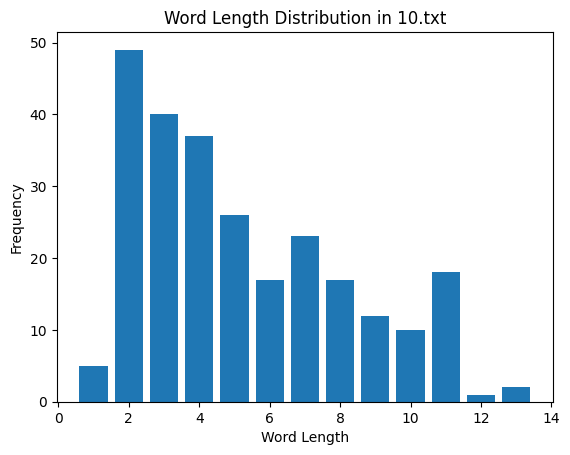

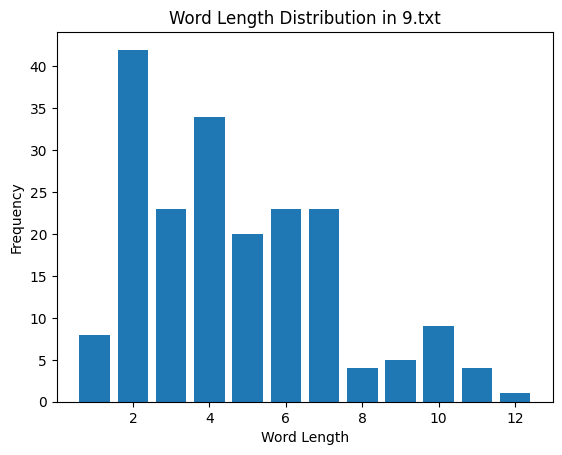

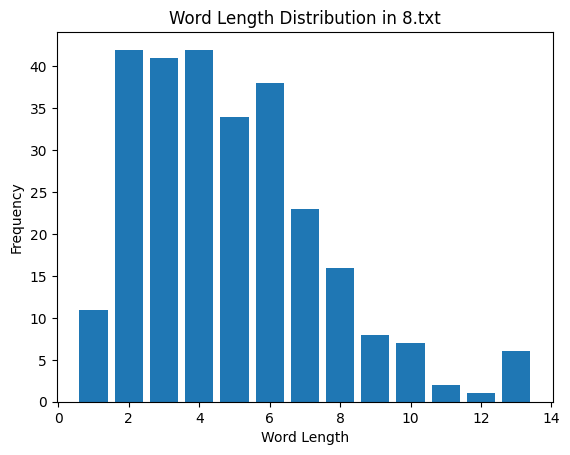

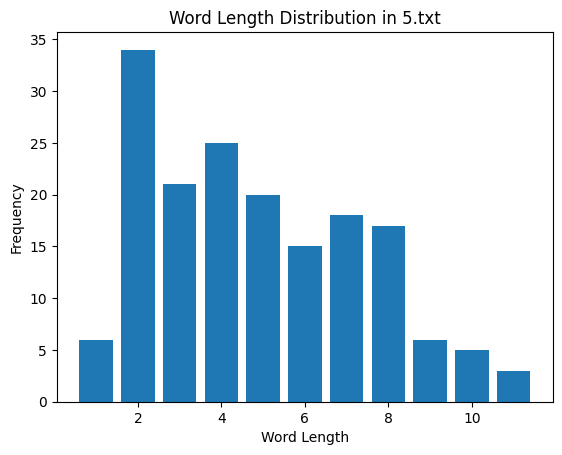

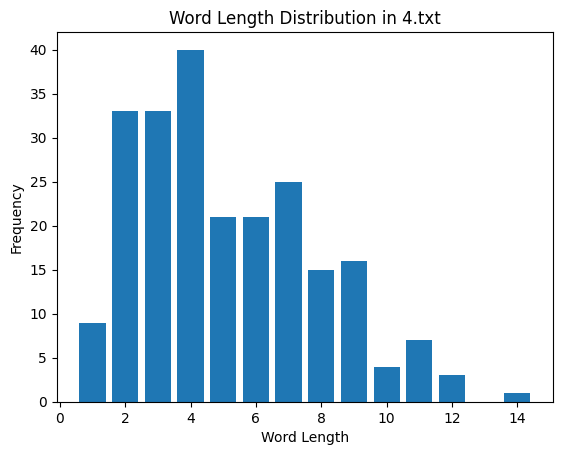

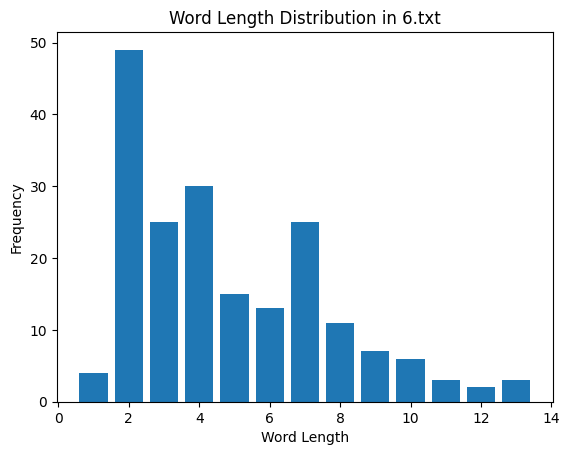

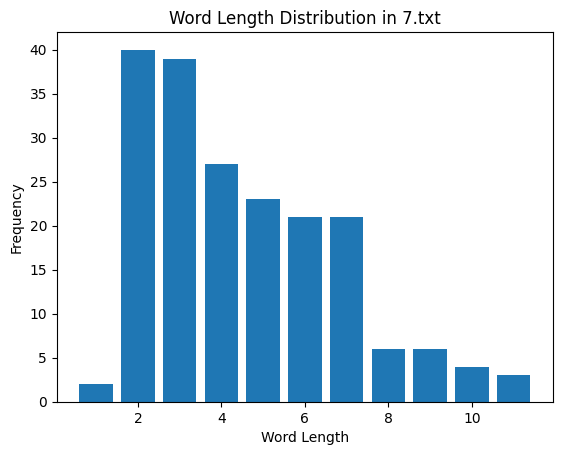

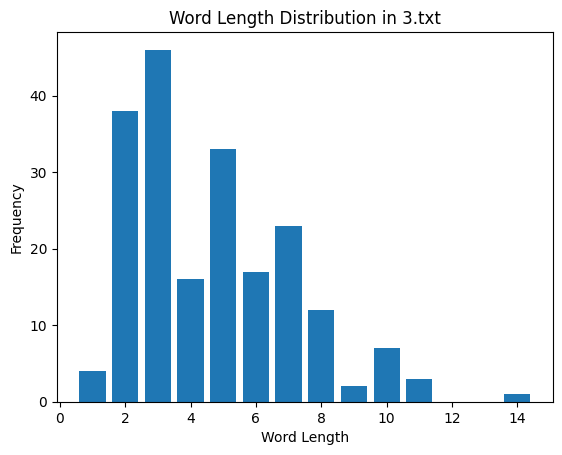

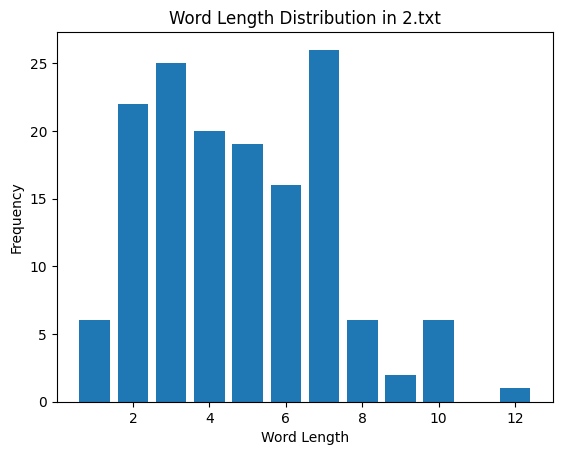

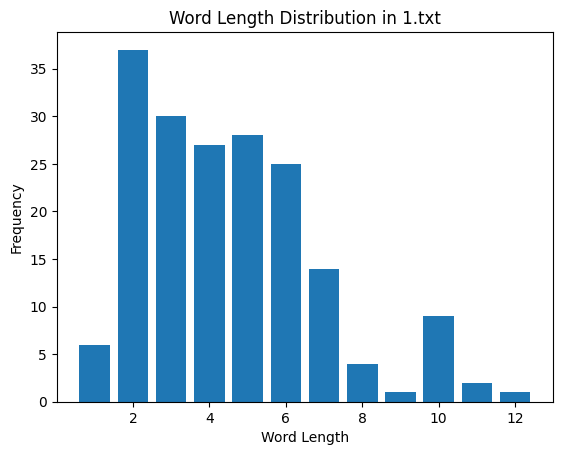

<Figure size 640x480 with 0 Axes>

In [24]:
import matplotlib.pyplot as plt
from collections import Counter

def plot_length_distribution(words, title):
    # Count the frequency of each word length
    word_lengths = [len(word) for word in words]
    word_length_counts = Counter(word_lengths)
    x = list(word_length_counts.keys())
    y = list(word_length_counts.values())
    # Plot the distribution of word lengths
    plt.bar(x, y)
    plt.title(title)
    plt.xlabel("Word Length")
    plt.ylabel("Frequency")
    plt.show()
    plt.savefig(f"./result/word_length_destribution_{title}.png", )

# Plot the distribution of word lengths in each essay
for key, value in words_list.items():
    plot_length_distribution(value, f"Word Length Distribution in {key}")
    # result[key]["Word Length Distribution"] = value


### 4.2 词汇多样性(Lexical diversity)
#### 概念
词汇多样性指学习者在语言使用中展现出的词汇范围(Malvern et al., 2004; Yu, 2010)。
#### 常用指标
- 形符-类符比(TTR, Type-Token Ratio)：指文本中形符数量与类符数量之比(Templin, 1957)。形符指文本中出现的所有不同词汇，类符指文本中出现的所有词汇。
- 移动平均形符-类符比(MATTR, Moving Average Type-Token Ratio)：也可以反映文本的词汇多样性(Covington & McFall, 2010)。相较于TTR，MATTR在计算时控制了文本的长度，得到的结果更加稳定。
#### 指标生成方法
Zenker & Kyle 在2021年开发了词汇多样性自动分析工具(TAALED: Tool for Automatic Analysis of Lexcial Diversity)，用于生成一系列关于词汇多样性指标。下面是代码演示如何使用TAALED生成本节示例文本的TTR和MATTR。

In [25]:
# https://www.linguisticanalysistools.org/taaled.html
# Zenker, F., & Kyle, K. (2021). Investigating minimum text lengths for lexical diversity indices. Assessing Writing, 47, 100505. https://doi.org/10.1016/j.asw.2020.100505

import src.TAALED.process_fn as process_fn_taaled

for filename, essay in essay_dict.items():
    refined_lemma_dict = process_fn_taaled.tag_processor_spaCy(essay, adj_word_list_path="src/TAALED/dep_files/adj_lem_list.txt", real_word_list_path="src/TAALED/dep_files/real_words.txt") # Process the essay using the functions in process_fn
    # Extract the lemma text and the content and function words
    lemma_text_aw = refined_lemma_dict["lemma"]
    lemma_text_cw = refined_lemma_dict["content"]
    lemma_text_fw = refined_lemma_dict["function"] 
    # Calculate the TTR and MATTR
    simple_ttr = process_fn_taaled.simple_ttr(lemma_text_aw)
    mattr_aw_50 = process_fn_taaled.mattr(lemma_text_aw, 50)
    print(f"Filename: {filename}")
    print(f"TTR: {simple_ttr}")
    # print(f"TTR: {simple_ttr}")
    print(f"MATTR: {mattr_aw_50}")
    result[filename]["TTR"] = simple_ttr
    result[filename]["MATTR"] = mattr_aw_50


Filename: 10.txt
TTR: 0.6071428571428571
MATTR: 0.8289655172413806
Filename: 9.txt
TTR: 0.5357142857142857
MATTR: 0.7624489795918374
Filename: 8.txt
TTR: 0.5703703703703704
MATTR: 0.7809954751131232
Filename: 5.txt
TTR: 0.5976331360946746
MATTR: 0.7488333333333337
Filename: 4.txt
TTR: 0.6222222222222222
MATTR: 0.8406818181818188
Filename: 6.txt
TTR: 0.5958549222797928
MATTR: 0.7979166666666654
Filename: 7.txt
TTR: 0.5416666666666666
MATTR: 0.746853146853147
Filename: 3.txt
TTR: 0.5472636815920398
MATTR: 0.75921052631579
Filename: 2.txt
TTR: 0.6554054054054054
MATTR: 0.809494949494949
Filename: 1.txt
TTR: 0.5911602209944752
MATTR: 0.8036363636363629


### 4.3 词汇密度(Lexical density)
#### 概念
词汇密度指的是文本中实词（相对于虚词）的数量与总词数的比例(Ure, 1971)。
#### 常用指标
- Lexical Density: 文本中实词与总次数的比例(Engber, 1995)。
#### 指标生成方法
同词汇多样性指标，词汇密度指标Density也可以使用TAALED工具自动生成。下面是代码演示如何使用TAALED生成本节示例文本的词汇密度。

In [26]:
# 网站：https://www.linguisticanalysistools.org/taaled.html
# 文献：Zenker, F., & Kyle, K. (2021). Investigating minimum text lengths for lexical diversity indices. Assessing Writing, 47, 100505. https://doi.org/10.1016/j.asw.2020.100505

import src.TAALED.process_fn as process_fn_taaled

for filename, essay in essay_dict.items():
    refined_lemma_dict = process_fn_taaled.tag_processor_spaCy(essay, adj_word_list_path="src/TAALED/dep_files/adj_lem_list.txt", real_word_list_path="src/TAALED/dep_files/real_words.txt") # Process the essay using the functions in process_fn
    # Extract the lemma text and the content and function words
    lemma_text_aw = refined_lemma_dict["lemma"]
    lemma_text_cw = refined_lemma_dict["content"]
    lemma_text_fw = refined_lemma_dict["function"] 
    # Calculate the lexical density
    [lexical_density_tokens, lexical_density_types] = process_fn_taaled.lex_density(lemma_text_cw, lemma_text_fw)
    print(f"Filename: {filename}")
    print(f"Lexical Density: {lexical_density_tokens}")
    result[filename]["Lexical Density"] = lexical_density_tokens

Filename: 10.txt
Lexical Density: 0.5357142857142857
Filename: 9.txt
Lexical Density: 0.4846938775510204
Filename: 8.txt
Lexical Density: 0.48148148148148145
Filename: 5.txt
Lexical Density: 0.5266272189349113
Filename: 4.txt
Lexical Density: 0.5644444444444444
Filename: 6.txt
Lexical Density: 0.48186528497409326
Filename: 7.txt
Lexical Density: 0.4010416666666667
Filename: 3.txt
Lexical Density: 0.47761194029850745
Filename: 2.txt
Lexical Density: 0.5405405405405406
Filename: 1.txt
Lexical Density: 0.46408839779005523


### 4.4 词汇复杂度(Lexical sophistication)
#### 概念
词汇复杂度指的是文本中“高级词汇”的使用比例。“高级词汇”既可以指词汇使用的多样性，也可以指复杂词汇的频繁使用。因此，词汇复杂度指标通常使用一个语料库作为基准参照，例如British National Corpus (BNC), Corpus of Contemporary American English (COCA)；或者更加专业的学术词汇语料库，例如Academic Word List (AWL) (Coxhead, 2000); Academic Formulas List (AFL) (Simpson-Vlach & Ellis, 2010) 。
#### 常用指标
- BNC word frequency: 文本中词汇在BNC语料库中词频的平均值(Kyle & Crossley, 2015)。其中包括写作语料库和口语语料库两个指标。
- Academic word list: 文本中词汇在AWL列表词汇中的频数(Kyle & Crossley, 2015)。
#### 指标生成方法
Kyle等人在2015年开发了自动化词汇复杂度分析工具(TAALES: Tool for Automatic Analysis of Lexical Sophistication)，并在后续进行了多次升级(Crossley & Kyle, 2018; Kyle et al., 2018)。该工具可以生成一系列词汇复杂度指标，包括频数指标，N元词组指标等。详细介绍参考https://www.linguisticanalysistools.org/taales.html。由于开发者尚未开源代码，我们无法提供代码示例。相关指标的计算可以通过官方网站下载图形化工具进行计算。

In [27]:
# 网站：https://www.linguisticanalysistools.org/taales.html
# 文献：Kyle, K., & Crossley, S. A. (2015). Automatically assessing lexical sophistication: Indices, tools, findings, and application. Tesol Quarterly, 49(4), 757–786. https://doi.org/10.1002/tesq.194

### 4.5 形态复杂度(Morphological complexity)
#### 概念
形态复杂度可以分为屈折变化复杂度(inflectional complexity)和派生变换复杂度(derivational compelxity):    
- 屈折变化复杂度：屈折变化表示一个词与其局部话语语境的关系，这种关系体现在时态、数等方面，而不改变词性或底层含义(Tywoniw & Crossley, 2020)。例如动词时态、语态、情态之间的变化，do变成doing或者done；或者名词性数格的变化，apple变成apples。
- 派生变化复杂度：派生形变化改变一个词的语义或句法类别（即改变意义或词性），通过在词的开头（前缀）或结尾（后缀）添加带有意义的单位(Tywoniw & Crossley, 2020)。例如同词根名词，形容词和副词之间的变换，interest变成interesting或者interestingly。
#### 常用指标
- 屈折变化复杂度指数(Inflectional mean complexity index)：反映屈折变化复杂度的综合指数，具体计算方法参见Brezina & Pallotti (2019)，指数越高，屈折变化越丰富
- 派生变化复杂度指数(Derivational mean complexity index)：反映派生变化复杂度的综合指数，具体计算方法参考Brezina & Pallotti (2019)，由Tywoniw & Crossley (2020)开发，指数越高，派生变化越丰富。
#### 指标生成方法
Tywoniw和Kyle两人在2022年开发了可以生成词汇形态复杂度指标的自动化分析工具(TAMMI: Tool for Automatic Morphological Complexity Measurement)，其中包括一系列词汇和形态复杂度指标，其中包括Inflectional_MCI_10和Derivational_MCI_10。下面是代码演示如何使用TAMMI生成本节示例文本的两个形态复杂度指标。

In [28]:
# 网站：https://www.linguisticanalysistools.org/tammi.html
# 文献：Tywoniw, R., & Crossley, S. (2020). Morphological complexity of L2 discourse. In The Routledge Handbook of Corpus Approaches to Discourse Analysis (pp. 269–297). Routledge.

# using TAMMI tool to analyze the morphological complexity of the essays
import src.TAMMI.process_fn as process_fn_tammi

for filename, essay in essay_dict.items():
    metric = process_fn_tammi.analyze_text(essay, "src/TAMMI/morpho_lex_df_w_log_w_prefsuf_no_head.csv")
    print(f"Filename: {filename}")
    # print(f"Result: {result}")
    print(f"inflectional MCI: {metric['inflectional MCI (10)']}")
    print(f"derivational MCI: {metric['derivational MCI (10)']}")
    result[filename]["inflectional MCI"] = metric['inflectional MCI (10)']
    result[filename]["derivational MCI"] = metric['derivational MCI (10)']

Filename: 10.txt
inflectional MCI: -0.23979591836734693
derivational MCI: -1.0
Filename: 9.txt
inflectional MCI: 0.17283950617283939
derivational MCI: -1.0
Filename: 8.txt
inflectional MCI: -0.485207100591716
derivational MCI: -1.0
Filename: 5.txt
inflectional MCI: -0.32098765432098775
derivational MCI: -1.0
Filename: 4.txt
inflectional MCI: -0.30177514792899407
derivational MCI: -1.0
Filename: 6.txt
inflectional MCI: -0.345679012345679
derivational MCI: -1.0
Filename: 7.txt
inflectional MCI: -0.234375
derivational MCI: -1.0
Filename: 3.txt
inflectional MCI: -0.49
derivational MCI: -0.9
Filename: 2.txt
inflectional MCI: -0.25
derivational MCI: -1.0
Filename: 1.txt
inflectional MCI: 0.012345679012345734
derivational MCI: -1.0


In [30]:
# save the result in the csv file
import csv
with open('./result/result.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    row_name = ["Filename", "Average Word Length", "TTR", "MATTR", "Lexical Density", "inflectional MCI", "derivational MCI"] 
    writer.writerow(row_name)
    for key, value in result.items():
        writer.writerow([key, value["Average Word Length"], value["TTR"], value["MATTR"], value["Lexical Density"], value["inflectional MCI"], value["derivational MCI"]])

## 5. 练习
1. 请根据课程代码，对本节示例文本使用LCA工具生成词汇多样性指标NDW和MSTTR-50
2. 请根据课程代码，对本节示例文本使用TAALES工具生成词汇复杂度指标COCA_Academic_Frequnecy_50和SUBTLEXus_Freq_AW。并且阅读Kyle & Crossley (2015)的文章，思考：如果生成的指标并不符合正态分布，直接用于后续的分析会有影响吗，为什么？